In [1]:
"""
plots for outputs of OVR
code adopted from 40_multiclass.ipynb

Shaina Lu
Zador & Gillis Labs
April 2021
"""

'\nplots for outputs of OVR\ncode adopted from 40_multiclass.ipynb\n\nShaina Lu\nZador & Gillis Labs\nApril 2021\n'

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #stratify train/test split
import random

In [3]:
def set_style():
    #function for matplotlib formatting
    plt.style.use(['seaborn-white','seaborn-notebook'])
    plt.rcParams['figure.figsize'] = [6,4]
    plt.rcParams['axes.spines.top'] = False       #remove top line
    plt.rcParams['axes.spines.right'] = False     #remove right line
    plt.rcParams['axes.linewidth'] = 2.0          #set weight of axes
    plt.rcParams['axes.titlesize'] = 20           #set font size of title
    plt.rcParams['axes.labelsize'] = 18           #set font size of x,y labels
    plt.rcParams['axes.labelpad'] = 14            #space between labels and axes
    plt.rcParams['xtick.labelsize'] = 14          #set x label size
    plt.rcParams['ytick.labelsize'] = 14          #set y label size
    plt.rcParams['legend.fontsize'] = 16          #set legend font size
    
set_style()

## regular data reads

In [4]:
#file paths
ALLEN_FILT_PATH = "/home/slu/spatial/data/ABAISH_filt_v6_avgdup.h5"
ONTOLOGY_PATH = "/data/slu/allen_adult_mouse_ISH/ontologyABA.csv"
ST_CANTIN_FILT_PATH = "/home/slu/spatial/data/cantin_ST_filt_v2.h5"

pre-processing functions in following hidden cell

In [5]:
def read_ABAdata():
    """read in all ABA datasets needed using pandas"""
    metabrain = pd.read_hdf(ALLEN_FILT_PATH, key='metabrain', mode='r')
    voxbrain = pd.read_hdf(ALLEN_FILT_PATH, key='avgvoxbrain', mode='r')
    propontvox = pd.read_hdf(ALLEN_FILT_PATH, key='propontology', mode='r')
    #geneIDName = pd.read_hdf(ALLEN_FILT_PATH, key='geneIDName', mode='r')	

    return metabrain, voxbrain, propontvox

#ST
def read_STdata():
    """read in all ST datasets needed using pandas"""
    STspotsmeta = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspotsmeta', mode='r')
    STspots = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STspots', mode='r')
    STpropont = pd.read_hdf(ST_CANTIN_FILT_PATH, key='STpropont', mode='r')
    
    return STspotsmeta, STspots, STpropont

def read_ontology():
    ontology = pd.read_csv(ONTOLOGY_PATH)
    ontology = ontology.drop([ontology.columns[5], ontology.columns[6]], axis=1)
    ontology = ontology.fillna(-1)  #make root's parent -1

    return ontology

def filterproponto(sampleonto):
    """pre-processing for propogated ontology"""
    #remove brain areas that don't have any samples
    sampleonto_sums = sampleonto.apply(lambda col: col.sum(), axis=0)
    sampleonto = sampleonto.loc[:,sampleonto_sums > 5] #greater than 5 becuase less is not enough for train/test split to have non-zero areas
    
    return sampleonto

def getleaves(propontvox, ontology):
    """helper function to get only leaf brain areas"""
    #leaves are brain areas in the ontology that never show up in the parent column
    allareas = list(propontvox)
    parents = list(ontology.parent)
    for i in range(len(parents)): #convert parents from float to int, ids are ints
        parents[i] = int(parents[i])
    
    #remove parents from all areas
    leaves = []
    for area in allareas:
        if int(area) not in parents:
            leaves.append(area)
    
    print("number of leaf areas: %d" %len(leaves))
    return leaves

def findoverlapareas(STonto, propontvox, ontology):
    """find leaf brain areas overlapping between the two datasets"""
    leafST = getleaves(STonto, ontology)
    leafABA = getleaves(propontvox, ontology)

    leafboth = [] 
    for i in range(len(leafABA)):
        if leafABA[i] in leafST:
            leafboth.append(leafABA[i])
    
    STonto = STonto.loc[:,leafboth]
    propontvox = propontvox.loc[:,leafboth]
    
    return STonto, propontvox    

def zscore(voxbrain):
    """zscore voxbrain or subsets of voxbrain (rows: voxels, cols: genes)"""
    #z-score on whole data set before splitting into test and train
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
    scaler.fit(voxbrain)
    z_voxbrain = scaler.transform(voxbrain)
    
    #store z-scored voxbrain as pandas dataframe
    z_voxbrain = pd.DataFrame(z_voxbrain)
    z_voxbrain.columns = voxbrain.columns
    z_voxbrain.index = voxbrain.index
    
    return z_voxbrain

def analytical_auroc(featurevector, binarylabels):
    """analytical calculation of auroc
       inputs: feature (mean rank of expression level), binary label (ctxnotctx)
       returns: auroc
    """
    #sort ctxnotctx binary labels by mean rank, aescending
    s = sorted(zip(featurevector, binarylabels))
    feature_sort, binarylabels_sort = map(list, zip(*s))

    #get the sum of the ranks in feature vector corresponding to 1's in binary vector
    sumranks = 0
    for i in range(len(binarylabels_sort)):
        if binarylabels_sort[i] == 1:
            sumranks = sumranks + feature_sort[i]
    
    poslabels = binarylabels.sum()
    neglabels = (len(binarylabels) - poslabels)
    
    auroc = ((sumranks/(neglabels*poslabels)) - ((poslabels+1)/(2*neglabels)))
    
    return auroc

def getoverlapgenes(STspots, ABAvox):
    ABAgenes = list(ABAvox)
    STgenes = list(STspots)
    
    #get overlapping genes
    overlap = []
    for i in range(len(ABAgenes)):
        if ABAgenes[i] in STgenes:
            overlap.append(ABAgenes[i])
    
    print("number of overlapping genes: %d" %len(overlap))
    
    #index datasets to keep only genes that are overlapping
    STspots = STspots.loc[:,overlap]
    ABAvox = ABAvox.loc[:,overlap]
    
    return STspots, ABAvox


In [6]:
#read in data ABA
ontology = read_ontology()
ABAmeta, ABAvox, ABApropont = read_ABAdata()

ABApropont = filterproponto(ABApropont)

#get leaf areas only
leaves = getleaves(ABApropont,ontology)
ABApropont = ABApropont.loc[ABAmeta.ids.isin(leaves),leaves] #subset propontvox for leaf areas
ABAvox = ABAvox.loc[ABAmeta.ids.isin(leaves),:] #subset voxbrain for voxels from leaves

number of leaf areas: 560


In [53]:
#read in data ST
ontology = read_ontology()
STspotsmeta, STspots, STpropont = read_STdata()
#pre-processing
STpropont = filterproponto(STpropont)
STspots = STspots.astype('float64') #convert int to float for z-scoring
#get leaf areas
leaves = getleaves(STpropont, ontology)
STpropont = STpropont.loc[STspotsmeta.id.isin(leaves),leaves] #subset prop onto for leaf areas
STspots = STspots.loc[STspotsmeta.id.isin(leaves),:] #subset data for samples from leaves

number of leaf areas: 461


# ABA (ranked predictions)

### read in data and combine files for ABA

In [7]:
ABATRAIN1 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040621_part1.csv"
ABATRAIN2 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040621_part2.csv"
ABATRAIN3 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040521_part3.csv"
ABATRAIN4 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040521_part4.csv"

ABATEST1 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040621_part1.csv"
ABATEST2 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040621_part2.csv"
ABATEST3 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040521_part3.csv"
ABATEST4 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040521_part4.csv"

In [8]:
ABAtrain1 = pd.read_csv(ABATRAIN1, sep=',')
ABAtrain2 = pd.read_csv(ABATRAIN2, sep=',')
ABAtrain3 = pd.read_csv(ABATRAIN3, sep=',')
ABAtrain4 = pd.read_csv(ABATRAIN4, sep=',')

In [32]:
ABAtrain1.iloc[:,140:280] = ABAtrain2.iloc[:,140:280]

In [33]:
ABAtrain1.iloc[:,280:420] = ABAtrain3.iloc[:,280:420]
ABAtrain1.iloc[:,420:560] = ABAtrain4.iloc[:,420:560]

In [34]:
ABAtest1 = pd.read_csv(ABATEST1, sep=',')
ABAtest2 = pd.read_csv(ABATEST2, sep=',')
ABAtest3 = pd.read_csv(ABATEST3, sep=',')
ABAtest4 = pd.read_csv(ABATEST4, sep=',')

In [35]:
ABAtest1.iloc[:,140:280] = ABAtest2.iloc[:,140:280]
ABAtest1.iloc[:,280:420] = ABAtest3.iloc[:,280:420]
ABAtest1.iloc[:,420:560] = ABAtest4.iloc[:,420:560]

### OVR re-ranking and Calculate AUROCs

In [39]:
#rank rows
ABAtrainranks = sp.stats.mstats.rankdata(ABAtrain1.to_numpy(),axis=1)
ABAtestranks = sp.stats.mstats.rankdata(ABAtest1.to_numpy(),axis=1)

#convert back to pandas
ABAtrainranks = pd.DataFrame(ABAtrainranks, index=ABAtrain1.index, columns=ABAtrain1.columns)
ABAtestranks = pd.DataFrame(ABAtestranks, index=ABAtest1.index, columns=ABAtest1.columns)

In [40]:
def getaurocs(mod_data,mod_propont,trainranks,testranks):
    #get aurocs
    trainauroc = {}
    testauroc = {}

    areas = list(mod_propont)
    #for each column, brain area
    for i in range(mod_propont.shape[1]):
        if i %5 == 0:
            print("col %d" %i)
        area1 = areas[i]

        #get binary label vectors
        ylabels = mod_propont.loc[:, area1]

        #split train test for X data and y labels
        #split data function is seeded so all will split the same way
        Xtrain, Xtest, ytrain, ytest = train_test_split(mod_data, ylabels, test_size=0.5,\
                                                        random_state=42, shuffle=True,\
                                                        stratify=ylabels)

        #get auroc of new prediction vector
        trainauroc[area1] = analytical_auroc(sp.stats.mstats.rankdata(trainranks[area1]), ytrain)
        testauroc[area1] = analytical_auroc(sp.stats.mstats.rankdata(testranks[area1]), ytest)
        
        
    return trainauroc,testauroc

In [ ]:
ABAtrainauroc,ABAtestauroc = getaurocs(ABAvox, ABApropont, ABAtrainranks, ABAtestranks)

col 0
col 5
col 10
col 15
col 20
col 25
col 30
col 35
col 40
col 45
col 50
col 55
col 60
col 65
col 70
col 75
col 80
col 85
col 90
col 95
col 100
col 105
col 110
col 115
col 120
col 125
col 130
col 135
col 140
col 145
col 150
col 155
col 160
col 165
col 170
col 175
col 180
col 185
col 190
col 195
col 200
col 205
col 210
col 215
col 220
col 225
col 230
col 235
col 240
col 245
col 250
col 255
col 260
col 265
col 270
col 275
col 280
col 285
col 290
col 295
col 300
col 305
col 310
col 315
col 320


In [ ]:
np.save("ABAtrainauroc_040521.npy", ABAtrainauroc)
np.save("ABAtestauroc_040521.npy", ABAtestauroc)

In [50]:
#CAN START HERE IN FUTURE
ABAtrainauroc = np.load("/home/slu/spatial/data/multiclass_OVR/ABAtrainauroc_040521.npy", allow_pickle=True)
ABAtestauroc = np.load("/home/slu/spatial/data/multiclass_OVR/ABAtestauroc_040521.npy", allow_pickle=True)

In [58]:
#convert to dicts
ABAtrainauroc = ABAtrainauroc.item()
ABAtestauroc = ABAtestauroc.item()

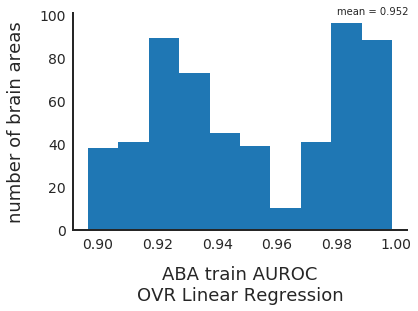

In [60]:
plt.hist(ABAtrainauroc.values())
plt.xlabel("ABA train AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.98,100,"mean = %.3f" %np.mean(list(ABAtrainauroc.values())))
#plt.savefig("041121_1.pdf", bbox_inches='tight')
plt.show()

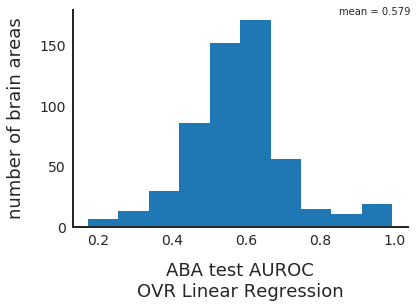

In [61]:
plt.hist(ABAtestauroc.values())
plt.xlabel("ABA test AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.85,175,"mean = %.3f" %np.mean(list(ABAtestauroc.values())))
#plt.savefig("041121_2.pdf", bbox_inches='tight')
plt.show()

plots by size

In [84]:
#get size
sizes = ABApropont.sum() 

In [93]:
#note these indices are in the same order for auroc dicts and size series
count = 0
for i in range(len(sizes.index)):
    if (sizes.index[i] == list(ABAtestauroc)[i]):
        count +=1
print(count)

560


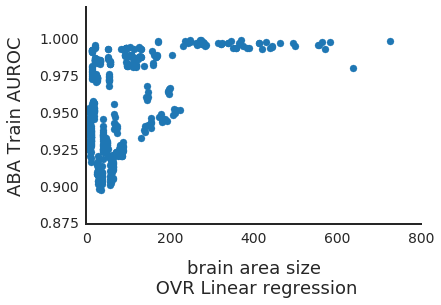

In [101]:
#plot auroc by size
plt.scatter(sizes, ABAtrainauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ABA Train AUROC")
plt.xlim([0,800])
plt.savefig("041221_4.pdf", bbox_inches='tight')
plt.show()

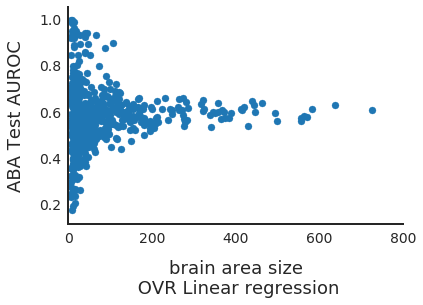

In [100]:
plt.scatter(sizes, ABAtestauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ABA Test AUROC")
plt.xlim([0,800])
plt.savefig("041221_3.pdf", bbox_inches='tight')
plt.show()

plots by non-multiclass auroc

In [161]:
ONETOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_onevallABA0_061420.csv"
ALLTOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_allvallABA0_061420.csv"

In [162]:
allvall = pd.read_csv(ALLTOALL)
onetoall = pd.read_csv(ONETOALL)
onetoall.index = allvall.columns
del(allvall)

In [124]:
#subset OVR ABA for only those that are present in onetoall
ABAtrainauroc_sub = pd.Series(ABAtrainauroc)
ABAtrainauroc_sub = ABAtrainauroc_sub.loc[ABAtrainauroc_sub.index.isin(onetoall.index)]

ABAtestauroc_sub = pd.Series(ABAtestauroc)
ABAtestauroc_sub = ABAtestauroc_sub.loc[ABAtestauroc_sub.index.isin(onetoall.index)]

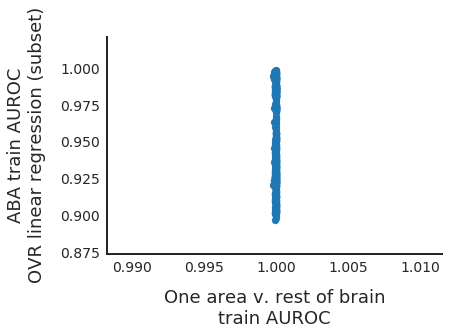

In [134]:
plt.scatter(onetoall.train, ABAtrainauroc_sub)
plt.xlabel("One area v. rest of brain\ntrain AUROC")
plt.ylabel("ABA train AUROC\nOVR linear regression (subset)")
plt.savefig("041221_5.pdf", bbox_inches='tight')
plt.show()

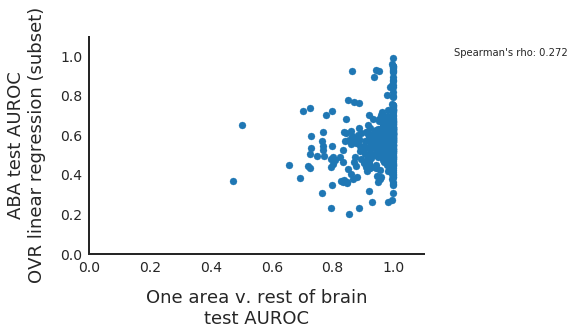

In [163]:
plt.scatter(onetoall.test, ABAtestauroc_sub)
plt.xlabel("One area v. rest of brain\ntest AUROC")
plt.ylabel("ABA test AUROC\nOVR linear regression (subset)")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.text(1.2,1,"Spearman's rho: %.3f" %(sp.stats.spearmanr(onetoall.test, ABAtestauroc_sub)[0]))
plt.savefig("041221_6.pdf",bbox_inches='tight')
plt.show()

# ABA (not ranked predictions)

### read in data and combine files for ABA

In [185]:
ABATRAIN1 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040821_nrpart1.csv"
ABATRAIN2 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040821_nrpart2.csv"
ABATRAIN3 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040821_nrpart3.csv"
ABATRAIN4 = "/home/slu/spatial/data/multiclass_OVR/ABAtrainpreds_040821_nrpart4.csv"

ABATEST1 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040821_nrpart1.csv"
ABATEST2 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040821_nrpart2.csv"
ABATEST3 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040821_nrpart3.csv"
ABATEST4 = "/home/slu/spatial/data/multiclass_OVR/ABAtestpreds_040821_nrpart4.csv"

In [186]:
ABAtrain1 = pd.read_csv(ABATRAIN1, sep=',')
ABAtrain2 = pd.read_csv(ABATRAIN2, sep=',')
ABAtrain3 = pd.read_csv(ABATRAIN3, sep=',')
ABAtrain4 = pd.read_csv(ABATRAIN4, sep=',')

In [187]:
ABAtrain1.iloc[:,140:280] = ABAtrain2.iloc[:,140:280]

In [188]:
ABAtrain1.iloc[:,280:420] = ABAtrain3.iloc[:,280:420]
ABAtrain1.iloc[:,420:560] = ABAtrain4.iloc[:,420:560]

In [189]:
ABAtest1 = pd.read_csv(ABATEST1, sep=',')
ABAtest2 = pd.read_csv(ABATEST2, sep=',')
ABAtest3 = pd.read_csv(ABATEST3, sep=',')
ABAtest4 = pd.read_csv(ABATEST4, sep=',')

In [190]:
ABAtest1.iloc[:,140:280] = ABAtest2.iloc[:,140:280]
ABAtest1.iloc[:,280:420] = ABAtest3.iloc[:,280:420]
ABAtest1.iloc[:,420:560] = ABAtest4.iloc[:,420:560]

### OVR re-ranking and Calculate AUROCs

In [191]:
#rank rows
ABAtrainranks = sp.stats.mstats.rankdata(ABAtrain1.to_numpy(),axis=1)
ABAtestranks = sp.stats.mstats.rankdata(ABAtest1.to_numpy(),axis=1)

#convert back to pandas
ABAtrainranks = pd.DataFrame(ABAtrainranks, index=ABAtrain1.index, columns=ABAtrain1.columns)
ABAtestranks = pd.DataFrame(ABAtestranks, index=ABAtest1.index, columns=ABAtest1.columns)

In [192]:
ABAtrainauroc,ABAtestauroc = getaurocs(ABAvox, ABApropont, ABAtrainranks, ABAtestranks)

col 0
col 5
col 10
col 15
col 20
col 25
col 30
col 35
col 40
col 45
col 50
col 55
col 60
col 65
col 70
col 75
col 80
col 85
col 90
col 95
col 100
col 105
col 110
col 115
col 120
col 125
col 130
col 135
col 140
col 145
col 150
col 155
col 160
col 165
col 170
col 175
col 180
col 185
col 190
col 195
col 200
col 205
col 210
col 215
col 220
col 225
col 230
col 235
col 240
col 245
col 250
col 255
col 260
col 265
col 270
col 275
col 280
col 285
col 290
col 295
col 300
col 305
col 310
col 315
col 320
col 325
col 330
col 335
col 340
col 345
col 350
col 355
col 360
col 365
col 370
col 375
col 380
col 385
col 390
col 395
col 400
col 405
col 410
col 415
col 420
col 425
col 430
col 435
col 440
col 445
col 450
col 455
col 460
col 465
col 470
col 475
col 480
col 485
col 490
col 495
col 500
col 505
col 510
col 515
col 520
col 525
col 530
col 535
col 540
col 545
col 550
col 555


In [193]:
np.save("ABAtrainauroc_040821.npy", ABAtrainauroc)
np.save("ABAtestauroc_040821.npy", ABAtestauroc)

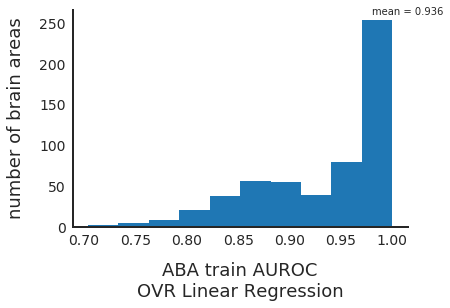

In [196]:
plt.hist(ABAtrainauroc.values())
plt.xlabel("ABA train AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.98,260,"mean = %.3f" %np.mean(list(ABAtrainauroc.values())))
plt.savefig("041321_1.pdf", bbox_inches='tight')
plt.show()

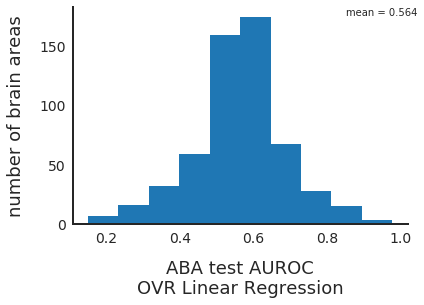

In [197]:
plt.hist(ABAtestauroc.values())
plt.xlabel("ABA test AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.85,175,"mean = %.3f" %np.mean(list(ABAtestauroc.values())))
plt.savefig("041321_2.pdf", bbox_inches='tight')
plt.show()

plots by size

In [198]:
#get size
sizes = ABApropont.sum() 

In [199]:
#note these indices are in the same order for auroc dicts and size series
count = 0
for i in range(len(sizes.index)):
    if (sizes.index[i] == list(ABAtestauroc)[i]):
        count +=1
print(count)
print(sizes.shape)

560
(560,)


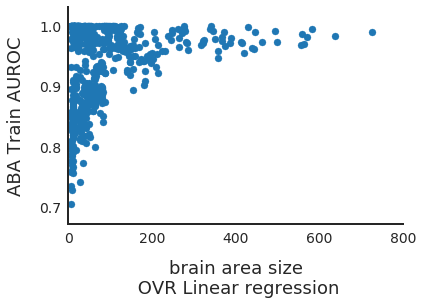

In [201]:
#plot auroc by size
plt.scatter(sizes, ABAtrainauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ABA Train AUROC")
plt.xlim([0,800])
plt.savefig("041321_4.pdf", bbox_inches='tight')
plt.show()

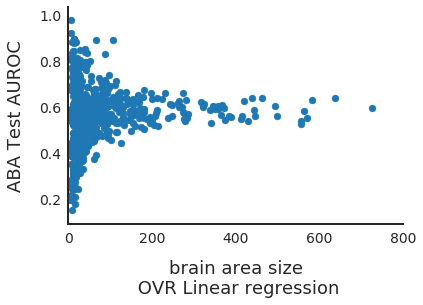

In [208]:
plt.scatter(sizes, ABAtestauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ABA Test AUROC")
plt.xlim([0,800])
plt.savefig("041321_6.pdf", bbox_inches='tight')
plt.show()

plots by non-multiclass auroc

In [209]:
ONETOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_onevallABA0_061420.csv"
ALLTOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_allvallABA0_061420.csv"

In [210]:
allvall = pd.read_csv(ALLTOALL)
onetoall = pd.read_csv(ONETOALL)
onetoall.index = allvall.columns
del(allvall)

In [211]:
#subset OVR ABA for only those that are present in onetoall
ABAtrainauroc_sub = pd.Series(ABAtrainauroc)
ABAtrainauroc_sub = ABAtrainauroc_sub.loc[ABAtrainauroc_sub.index.isin(onetoall.index)]

ABAtestauroc_sub = pd.Series(ABAtestauroc)
ABAtestauroc_sub = ABAtestauroc_sub.loc[ABAtestauroc_sub.index.isin(onetoall.index)]

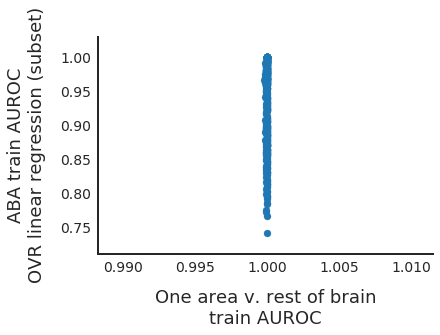

In [212]:
plt.scatter(onetoall.train, ABAtrainauroc_sub)
plt.xlabel("One area v. rest of brain\ntrain AUROC")
plt.ylabel("ABA train AUROC\nOVR linear regression (subset)")
plt.savefig("041321_7.pdf", bbox_inches='tight')
plt.show()

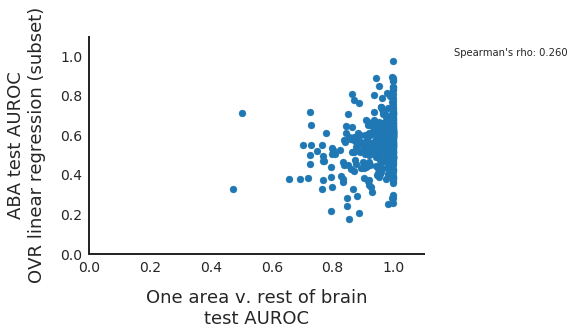

In [213]:
plt.scatter(onetoall.test, ABAtestauroc_sub)
plt.xlabel("One area v. rest of brain\ntest AUROC")
plt.ylabel("ABA test AUROC\nOVR linear regression (subset)")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.text(1.2,1,"Spearman's rho: %.3f" %(sp.stats.spearmanr(onetoall.test, ABAtestauroc_sub)[0]))
plt.savefig("041321_8.pdf",bbox_inches='tight')
plt.show()

# ST (not ranked predictions)

In [51]:
STTRAIN = "/home/slu/spatial/data/multiclass_OVR/STtrainpreds_040821.csv"
STTEST = "/home/slu/spatial/data/multiclass_OVR/STtestpreds_040821.csv"

In [52]:
STtrain = pd.read_csv(STTRAIN, sep=',')
STtest = pd.read_csv(STTEST, sep=',')

### OVR re-ranking and Calculate AUROCs

In [54]:
#rank rows
STtrainranks = sp.stats.mstats.rankdata(STtrain.to_numpy(),axis=1)
STtestranks = sp.stats.mstats.rankdata(STtest.to_numpy(),axis=1)

#convert back to pandas
STtrainranks = pd.DataFrame(STtrainranks, index=STtrain.index, columns=STtrain.columns)
STtestranks = pd.DataFrame(STtestranks, index=STtest.index, columns=STtest.columns)

In [55]:
STtrainauroc,STtestauroc = getaurocs(STspots, STpropont, STtrainranks, STtestranks)

col 0
col 5
col 10
col 15
col 20
col 25
col 30
col 35
col 40
col 45
col 50
col 55
col 60
col 65
col 70
col 75
col 80
col 85
col 90
col 95
col 100
col 105
col 110
col 115
col 120
col 125
col 130
col 135
col 140
col 145
col 150
col 155
col 160
col 165
col 170
col 175
col 180
col 185
col 190
col 195
col 200
col 205
col 210
col 215
col 220
col 225
col 230
col 235
col 240
col 245
col 250
col 255
col 260
col 265
col 270
col 275
col 280
col 285
col 290
col 295
col 300
col 305
col 310
col 315
col 320
col 325
col 330
col 335
col 340
col 345
col 350
col 355
col 360
col 365
col 370
col 375
col 380
col 385
col 390
col 395
col 400
col 405
col 410
col 415
col 420
col 425
col 430
col 435
col 440
col 445
col 450
col 455
col 460


In [56]:
np.save("STtrainauroc_041121.npy", ABAtrainauroc)
np.save("STtestauroc_041121.npy", ABAtestauroc)

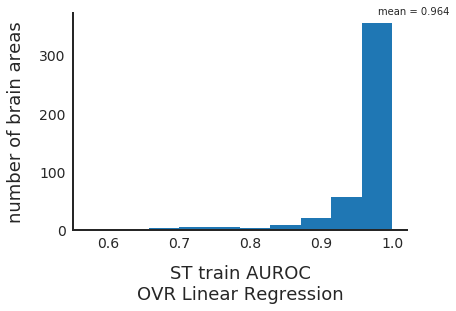

In [136]:
plt.hist(STtrainauroc.values())
plt.xlabel("ST train AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.98,370,"mean = %.3f" %np.mean(list(STtrainauroc.values())))
#plt.savefig("041121_3.pdf", bbox_inches='tight')
plt.show()

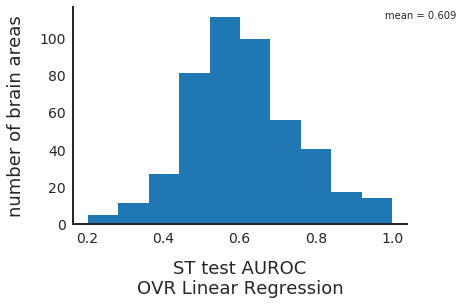

In [137]:
plt.hist(STtestauroc.values())
plt.xlabel("ST test AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.98,110,"mean = %.3f" %np.mean(list(STtestauroc.values())))
#plt.savefig("041121_4.pdf", bbox_inches='tight')
plt.show()

plots by size

In [138]:
#get size
sizes = STpropont.sum() 

In [141]:
#note these indices are in the same order for auroc dicts and size series
count = 0
for i in range(len(sizes.index)):
    if (sizes.index[i] == list(STtestauroc)[i]):
        count +=1
print(count)
print(sizes.shape)

461
(461,)


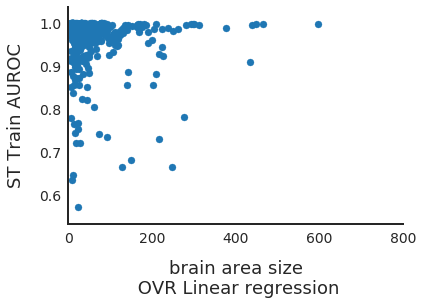

In [143]:
#plot auroc by size
plt.scatter(sizes, STtrainauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ST Train AUROC")
plt.xlim([0,800])
plt.savefig("041221_8.pdf", bbox_inches='tight')
plt.show()

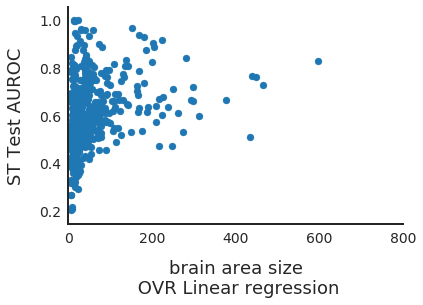

In [145]:
plt.scatter(sizes, STtestauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ST Test AUROC")
plt.xlim([0,800])
plt.savefig("041221_10.pdf", bbox_inches='tight')
plt.show()

plots by non-multiclass auroc

In [146]:
ONETOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_onevallST0_061320.csv"
ALLTOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_allvallST0_061320.csv"

In [147]:
allvall = pd.read_csv(ALLTOALL)
onetoall = pd.read_csv(ONETOALL)
onetoall.index = allvall.columns
del(allvall)

In [148]:
#subset OVR ST for only those that are present in onetoall
STtrainauroc_sub = pd.Series(STtrainauroc)
STtrainauroc_sub = STtrainauroc_sub.loc[STtrainauroc_sub.index.isin(onetoall.index)]

STtestauroc_sub = pd.Series(STtestauroc)
STtestauroc_sub = STtestauroc_sub.loc[STtestauroc_sub.index.isin(onetoall.index)]

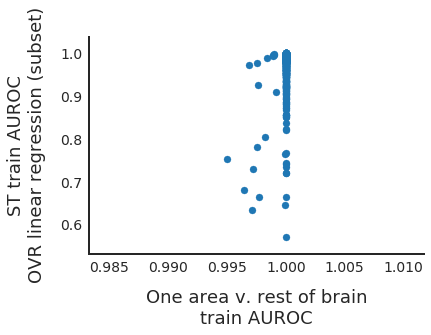

In [153]:
plt.scatter(onetoall.train, STtrainauroc_sub)
plt.xlabel("One area v. rest of brain\ntrain AUROC")
plt.ylabel("ST train AUROC\nOVR linear regression (subset)")
plt.savefig("041221_11.pdf", bbox_inches='tight')
plt.show()

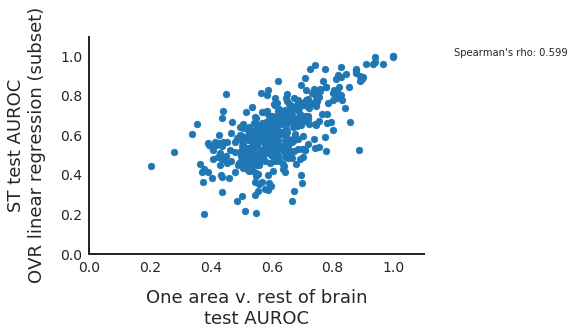

In [160]:
plt.scatter(onetoall.test, STtestauroc_sub)
plt.xlabel("One area v. rest of brain\ntest AUROC")
plt.ylabel("ST test AUROC\nOVR linear regression (subset)")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.text(1.2,1,"Spearman's rho: %.3f" %(sp.stats.spearmanr(onetoall.test, STtestauroc_sub)[0]))
plt.savefig("041221_12.pdf",bbox_inches='tight')
plt.show()

# ST (ranked predictions)

In [164]:
STTRAIN = "/home/slu/spatial/data/multiclass_OVR/STtrainpreds_040321.csv"
STTEST = "/home/slu/spatial/data/multiclass_OVR/STtestpreds_040321.csv"

In [165]:
STtrain = pd.read_csv(STTRAIN, sep=',')
STtest = pd.read_csv(STTEST, sep=',')

### OVR re-ranking and Calculate AUROCs

In [166]:
#rank rows
STtrainranks = sp.stats.mstats.rankdata(STtrain.to_numpy(),axis=1)
STtestranks = sp.stats.mstats.rankdata(STtest.to_numpy(),axis=1)

#convert back to pandas
STtrainranks = pd.DataFrame(STtrainranks, index=STtrain.index, columns=STtrain.columns)
STtestranks = pd.DataFrame(STtestranks, index=STtest.index, columns=STtest.columns)

In [167]:
STtrainauroc,STtestauroc = getaurocs(STspots, STpropont, STtrainranks, STtestranks)

col 0
col 5
col 10
col 15
col 20
col 25
col 30
col 35
col 40
col 45
col 50
col 55
col 60
col 65
col 70
col 75
col 80
col 85
col 90
col 95
col 100
col 105
col 110
col 115
col 120
col 125
col 130
col 135
col 140
col 145
col 150
col 155
col 160
col 165
col 170
col 175
col 180
col 185
col 190
col 195
col 200
col 205
col 210
col 215
col 220
col 225
col 230
col 235
col 240
col 245
col 250
col 255
col 260
col 265
col 270
col 275
col 280
col 285
col 290
col 295
col 300
col 305
col 310
col 315
col 320
col 325
col 330
col 335
col 340
col 345
col 350
col 355
col 360
col 365
col 370
col 375
col 380
col 385
col 390
col 395
col 400
col 405
col 410
col 415
col 420
col 425
col 430
col 435
col 440
col 445
col 450
col 455
col 460


In [168]:
np.save("STtrainauroc_040321.npy", ABAtrainauroc)
np.save("STtestauroc_040321.npy", ABAtestauroc)

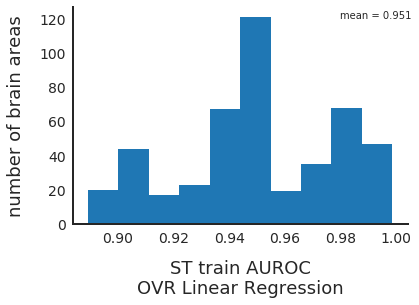

In [170]:
plt.hist(STtrainauroc.values())
plt.xlabel("ST train AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.98,120,"mean = %.3f" %np.mean(list(STtrainauroc.values())))
plt.show()

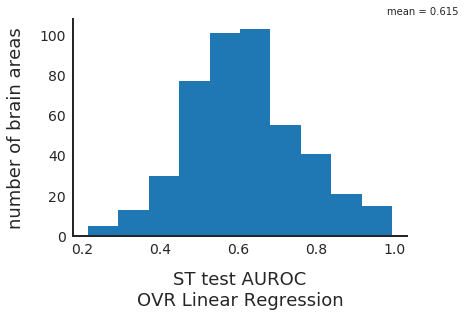

In [171]:
plt.hist(STtestauroc.values())
plt.xlabel("ST test AUROC\nOVR Linear Regression")
plt.ylabel("number of brain areas")
plt.text(0.98,110,"mean = %.3f" %np.mean(list(STtestauroc.values())))
plt.show()

plots by size

In [172]:
#get size
sizes = STpropont.sum() 

In [173]:
#note these indices are in the same order for auroc dicts and size series
count = 0
for i in range(len(sizes.index)):
    if (sizes.index[i] == list(STtestauroc)[i]):
        count +=1
print(count)
print(sizes.shape)

461
(461,)


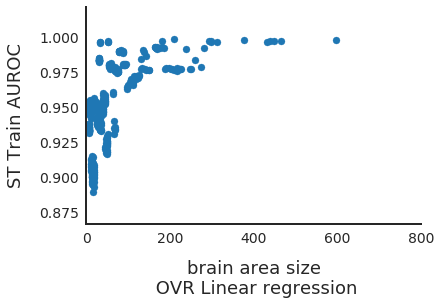

In [176]:
#plot auroc by size
plt.scatter(sizes, STtrainauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ST Train AUROC")
plt.xlim([0,800])
plt.savefig("041221_14.pdf", bbox_inches='tight')
plt.show()

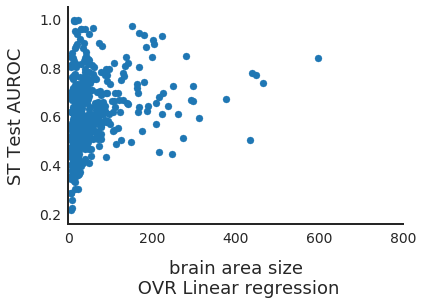

In [178]:
plt.scatter(sizes, STtestauroc.values())
plt.xlabel("brain area size\n OVR Linear regression")
plt.ylabel("ST Test AUROC")
plt.xlim([0,800])
plt.savefig("041221_16.pdf", bbox_inches='tight')
plt.show()

plots by non-multiclass auroc

In [179]:
ONETOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_onevallST0_061320.csv"
ALLTOALL = "/home/slu/spatial/data/onetoall_lasso/onetoall_allvallST0_061320.csv"

In [180]:
allvall = pd.read_csv(ALLTOALL)
onetoall = pd.read_csv(ONETOALL)
onetoall.index = allvall.columns
del(allvall)

In [181]:
#subset OVR ST for only those that are present in onetoall
STtrainauroc_sub = pd.Series(STtrainauroc)
STtrainauroc_sub = STtrainauroc_sub.loc[STtrainauroc_sub.index.isin(onetoall.index)]

STtestauroc_sub = pd.Series(STtestauroc)
STtestauroc_sub = STtestauroc_sub.loc[STtestauroc_sub.index.isin(onetoall.index)]

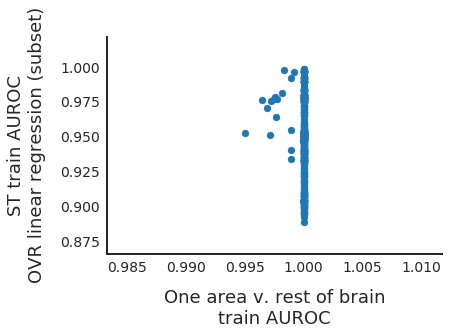

In [182]:
plt.scatter(onetoall.train, STtrainauroc_sub)
plt.xlabel("One area v. rest of brain\ntrain AUROC")
plt.ylabel("ST train AUROC\nOVR linear regression (subset)")
plt.savefig("041221_17.pdf", bbox_inches='tight')
plt.show()

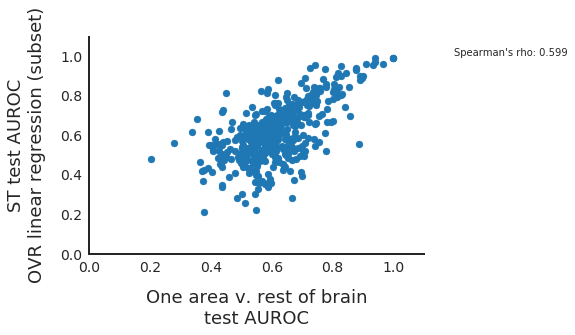

In [183]:
plt.scatter(onetoall.test, STtestauroc_sub)
plt.xlabel("One area v. rest of brain\ntest AUROC")
plt.ylabel("ST test AUROC\nOVR linear regression (subset)")
plt.xlim([0,1.1])
plt.ylim([0,1.1])
plt.text(1.2,1,"Spearman's rho: %.3f" %(sp.stats.spearmanr(onetoall.test, STtestauroc_sub)[0]))
plt.savefig("041221_18.pdf",bbox_inches='tight')
plt.show()